# Úvod do strojového učení


### Úkol 0: 

Co si představuješ pod pojmem strojové učení? 


![ilustracni_obr](static/ml_small.jpg)

Bonus: [komiks o tom, co to to strojové učení je](https://cloud.google.com/products/ai/ml-comic-1/)

### Ilustrační příklad na úvod - *imaginární krajina*

Dnešní hodina je trochu jiná, nebudeš se tolik zaměřovat na programování, to není při aplikaci strojového učení zas až tolik potřeba. Důležitejší je vědět, co chceš dělat a proč. Proto je naším cílem donutit tě přemýšlet. 

Půjdeme na to proto od lesa a začneme příkladem. 

Představ si, že sis najala zeměměřiče a vyslala ho do neznámé krajiny. Zadala jsi mu souřadnice několika bodů (žiješ teď v zjednodušeném prostoru, souřadnice je tedy pouze jedno číslo) a on pro tebe naměřil zeměpisnou výšku v těchto bodech.   

Naměřené body máš zobrazeny na obrázku, který jsi obdržela na hodině vytištěný od kouče. Studuješ-li doma, můžeš si jej vytisknout ([PDF](static/krajina_public.pdf)).

In [1]:
TAJNE = 2 # pokud se účastníš hodiny s koučem, toto číslo změň dle instrukcí

*Kód níže nás nebude zajímat, slouží jen vygenerování obrázku "krajinky" (pro milovníky matematiky funkce).* 


In [2]:
%matplotlib inline

In [3]:
# importujeme knihovny jako obvykle
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# nastavíme velikost obrázku na 20 x 10 (inches)
plt.rcParams["figure.figsize"] = (20, 10)

# knihovna Scikitlearn občas produkuje warningy, které nás 
# nemusí znepokojovat 
# potlačíme jejich výpis 
import warnings
warnings.filterwarnings('ignore')

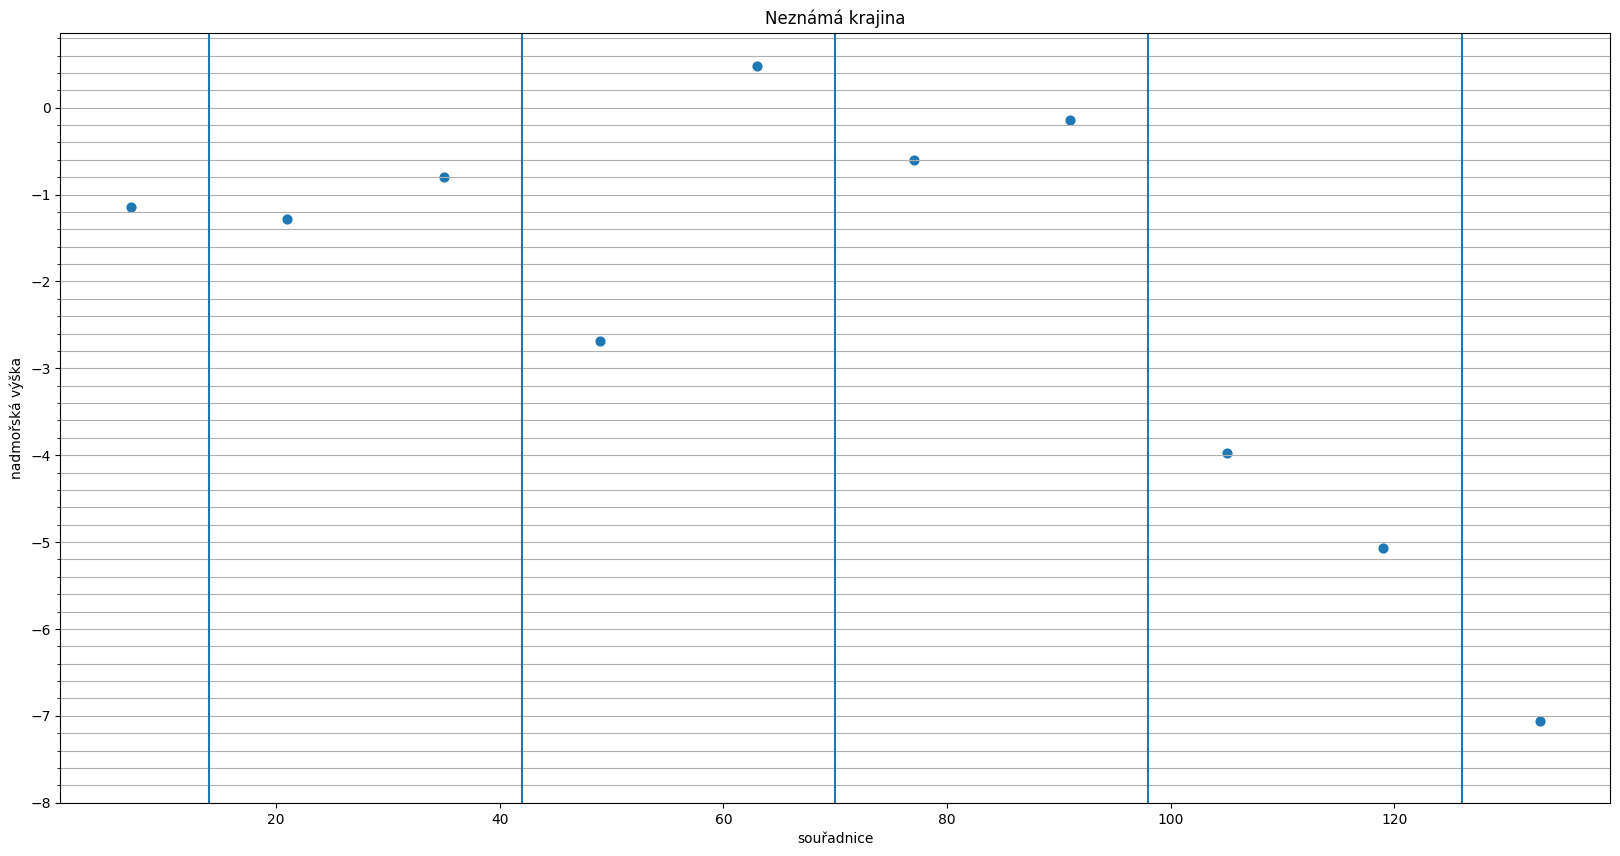

In [4]:
# kód v této buňce nám slouží k vygenerování krajiny a její zobrazování
# nečti jej, není v této hodině potřeba mu rozumět

ticks_per_1 = 5


TRAIN_START = 7
TRAIN_STEP = 14 

TEST_START = 1+13
TEST_STEP  = 14*2

lim = 140 # počet řádek  

def fn(x):
    "Funkce, která reprezentuje krajinu."
    x /= 10
    return TAJNE*TAJNE + math.sin(x) + math.cos(TAJNE*x) + 0.2/TAJNE * x**2 - 0.1**TAJNE * x**(5-TAJNE) -6

df_krajina = pd.DataFrame(index=range(0, lim))
df_krajina["y"] = pd.Series(df_krajina.index).apply(fn)

df_krajina["y_sample"] = df_krajina["y"].loc[TRAIN_START::TRAIN_STEP]
df_krajina["y_test"] = df_krajina["y"].loc[TEST_START::TEST_STEP]

df_krajina["x_sample"] = df_krajina.index
df_krajina.loc[df_krajina["y_sample"].isnull(), "x_sample"] = None
df_krajina["x_test"] = df_krajina.index
df_krajina.loc[df_krajina["y_test"].isnull(), "x_test"] = None

def nakresli_krajinku(df, predicted=None, plot_gold=True):
    
    ax = df.plot(x="x_sample", y="y_sample", s=40, kind="scatter")
    margin = 10 # nemusi se pak resit rozsah obrazku
    if plot_gold:
        ax = df["y"].loc[margin:len(df)-margin].plot()
    if predicted:
        ax = df[predicted].loc[margin:len(df)-margin].plot()
    for tst_val in df["x_test"]:
        ax.axvline(tst_val)
        if predicted and not tst_val != tst_val:
            ax.plot(
                [tst_val, tst_val],
                [df.loc[tst_val, "y"], df.loc[tst_val, predicted]],
                marker = '_', color="red", linestyle="-", linewidth=3
            )
 

    y_bottom, y_top = ax.get_ylim()
    ax.set_yticks([x/ticks_per_1 for x in range(int(y_bottom-1)*ticks_per_1, int(y_top+1)*ticks_per_1)], minor=True)
    ax.set_xlabel("souřadnice")
    ax.set_ylabel("nadmořská výška")
    ax.set_title("Neznámá krajina")
    ax.grid(True, which='both', axis='y')
    return ax

nakresli_krajinku(df_krajina, plot_gold=False);


Po naměření těchto bodů se zeměměřič rozhodl státi datovým analytikem,
přihlásil se na kurz od PyLadies a s měřením definivně skončil. 
Nás by ale zajímalo, jak by asi tak mohla celá krajina vypadat.

### Úkol 1:
Vezmi si tužku a zkus si na výše uvedeném obrázku nakreslit 
krajinu tak, jak si ji dle daných měření představuješ. (Nejde nám o interpolaci! Není nutné, aby tvoje *čára* vedla přímo skrz dané body. Uvědom si, že měření mohou být zatížena chybou. Zeměměřič také měřil pouze v bodech, které jsi mu zadala (vybrala náhodně), nemusí to tedy být ani vrcholy, ani údolí, ani jiné význačné body.).

**Otázky:** 
+ Jsi si svým odhadem jistá? Existuje více možností, jak by mohla krajina vypadat?
+ Jak bys změřila (vyčíslila) kvalitu své schopnosti odhadovat neznámou krajinu?  
+ Podívej se na krajinku své sousedky. Zamysli se nad tím, jak by se dalo určit, která z vás krajinku vystihla lépe.



### Metrika

Z předchozího úkolu plyne, že existuje hodně možností, jak by mohla krajina vypadat. 

Také že potřebujeme nějakou míru, která nám umožní kvantifikovat kvalitu řešení. 

K tomu slouží tzv. **metriky**. 
Jak už z názvu vyplývá, metrika nám umožňuje něco měřit.
My potřebujeme měřit chybu něčeho. Na první pohled je to snadný úkol. Ale popravdě až zas tak ne.

Je lepší, když pro požadované hodnoty `[10, 30, 20]` dodáme výsledek `[12, 32, 22]`, nebo bude lepší výsledek `[15, 30, 20]`? A my to navíc potřebujeme zapsat matematicky, aby to i ten počítač chápal... 


## Odtajnění
Než se to pokusíme pro počítač zformulovat, podíváme se, jak neznámá krajina vypadá. (Pokud právě sedíš na kurzu, nezapomeň opravit hodnotu proměnné TAJNE dle instrukce kouče, abys dostala obrázek odpovídající tomu, který máš vytištěný.)

*Neznámou krajinu vidíme jen díky tomu, že se jedná o cvičnou úlohu. V praxi bychom ji nikdy celou k dispozici neměli.* 

Teď, když vidíš opravdovou podobu krajinky, tak bys ji určitě kreslila jinak. I proto jsme ti to `TAJNE` číslo tajili. Kdybys dopředu viděla, jak má krajinka vypadat, tak by ono vyhodnocení nemohlo být nikdy férové.



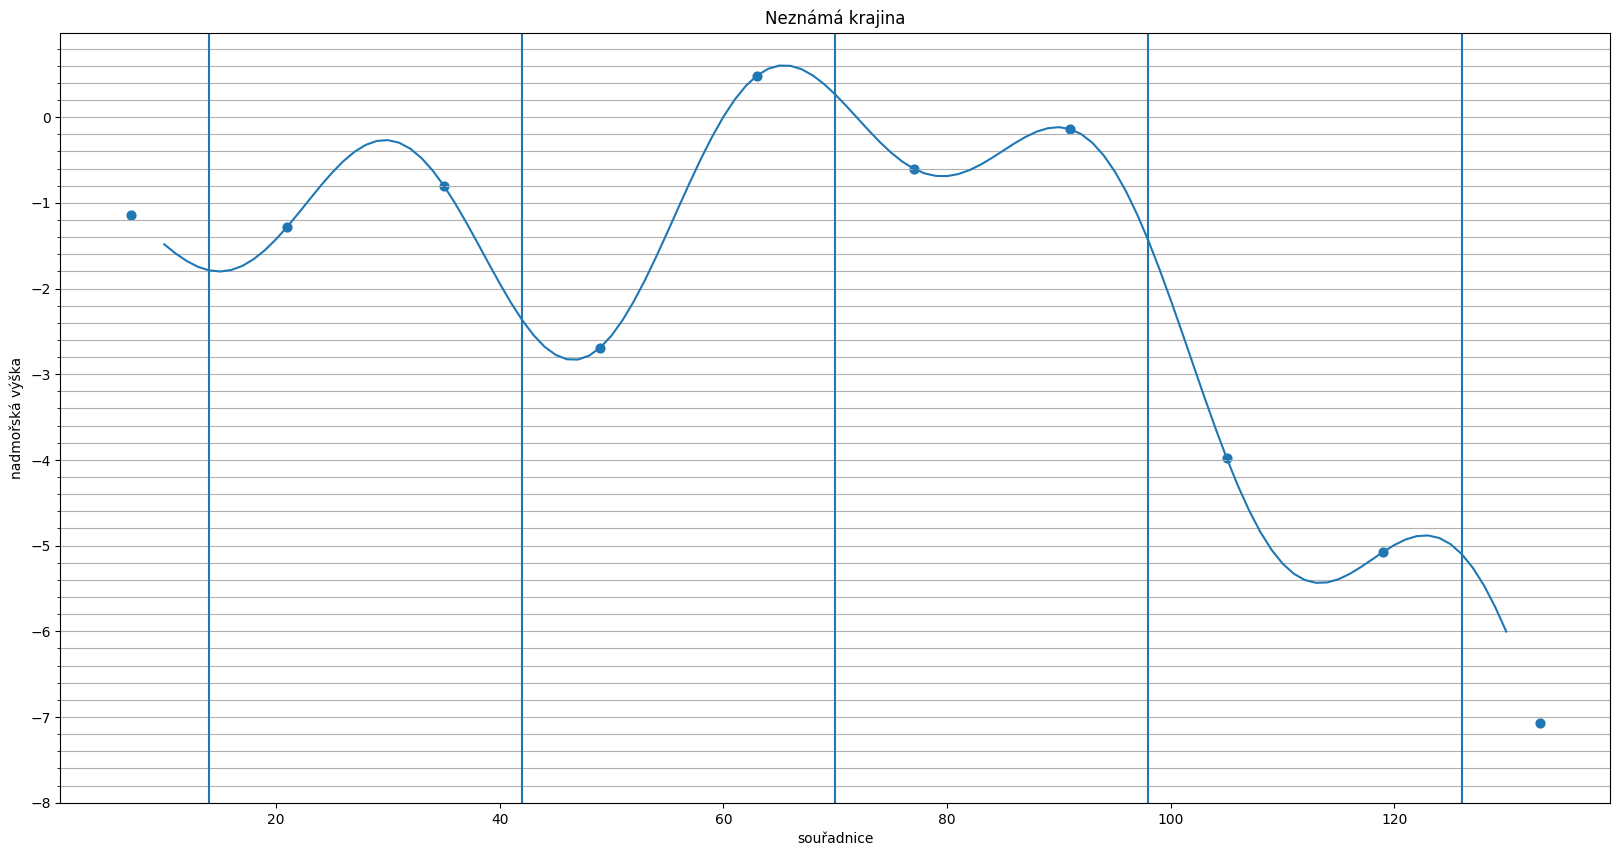

In [5]:
nakresli_krajinku(df_krajina);

### Úkol 2:

Pomocí mřížky na obrázku odečti hodnoty nadmořské výšky ze své krajinky v bodech vyznačených modrou čarou a doplň do tabulky v následujícím kódu.

In [6]:
__ = None  # pouze proto, aby kód byl syntakticky správně
df_krajina["můj_odhad"] = pd.Series()
df_krajina["můj_odhad"].loc[TEST_START::TEST_STEP]= [ -1.2, -1.8, 0, -2.6, -6] # doplň čísla 


Dobrá zpráva je, že jsme předvídavě nechali nějaké body stranou, na obrázku jsou vyznačeny modrou čarou. 
Hodnoty odpovídající těmto bodům najdeš ve sloupečku `"x_test"` a `"y_test"` DataFramu `df_krajina`. 

Napiš funkci (**metriku**), která vyhodnotí, jak moc byl odhad tvé krajinky úspěšný.

+ Použij svoji metriku a urči, zda je z tvého pohledu úspěšný tvůj nebo sousedčin odhad.
+ Zatím víš jen, jestli jsi lepší než sousedka nebo ne. Ale jak určit, zda schopnost člověka odhadnout krajinku za něco stojí nebo ne?


#### Jak zapíšeme metriku?

Je to funkce, která vezme **správné** a **odhadnuté** hodnoty a vyrobí z nich nějakou číselnou reprezentaci **správnosti**.

**Pozor**: funkci budeme jako argumenty zadávat objekty pd.Series, které budou na některých řádcích obsahovat hodnoty `NaN`. Tyto řádky má funkce ignorovat. Pokud využiješ operace nad celými sloupci (Series), nebudou ti tyto hodnoty vadit. Např. `y_true - y_pred` vytvoří objekt Series, který bude obsahovat odpovídající rozdíly a tam, kde byly hodnoty `NaN`, bude `NaN` i ve výsledku.

In [10]:
def moje_metrika(y_true, y_pred):
    """ Funkce vyhodnotí úspěšnost predikce krajinky (funkce). 
    y_true jsou skutečné hodnoty, y_pred jsou predikované hodnoty.
    """
    jed_chyba = y_true - y_pred
    chyba_n2 = jed_chyba * jed_chyba
    celkova_chyba = chyba_n2.sum()
    return celkova_chyba
    
moje_metrika(df_krajina["y_test"], df_krajina["můj_odhad"])

2.8929935273505443

Zkusíme vzít hloupý odhad a podívat se, jestli je naše řešení lepší. 


In [19]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_krajina["y_test"].dropna(), df_krajina["můj_odhad"].dropna())

0.5785987054701088

In [20]:
mean_value = df_krajina["y_sample"].mean()
df_krajina["jednoduchý_odhad"] = pd.Series()
df_krajina["jednoduchý_odhad"].loc[TEST_START::TEST_STEP] = mean_value

moje_metrika(df_krajina["y_test"], df_krajina["jednoduchý_odhad"])

np.float64(15.265475125605231)

##  Konečně ke strojovému učení ...

Teď přichází jediná dobrá zpráva z dnešní lekce. **Strojové učení** (machine learning) nabízí metody (algoritmy), které dokáží méně či více úspěšně provést obdobný odhad (nejen) krajinky za tebe. 

Představ si tuto metodu jako *černou krabičku*, která má nějaké vstupy a nějaké výstupy. Takové krabičce se říká **model**. Do vstupů můžeš sypat čísla (seznamy čísel) a krabička na výstupu bude chrlit odpovědi (také čísla, třeba nadmořskou výšku).
V případě krajinky zadáš souřadnici (třeba seznam souřadnic $[x_1, x_2]$) a krabička ti prozradí, jaká je v daném bodě nadmořská výška. Souřadnice, které jdou na vstup *krabičky* (modelu), označujeme jako příznaky (**features**) nebo vstupní proměnné, regressory. Na výstupu je nějaká odezva (závislá proměnná). 

![černá skříňka](static/blackbox.png)



Samozřejmě krabička nemůže sama od sebe vědět, zda se ptáš na krajinu v Krkonoších nebo v Polabí. Proto je třeba krabičku nejprve **naučit** (natrénovat, nafitovat) na úkol, který po ní budeme požadovat. V podstatě do krabičky v nějaké formě uložíme to, co zatím o krajince víme.
Krabička to zvládne sama, my jí jen musíme poskynout dostatečné množství příkladů (trénovacích vzorů) souřadnic a odpovídajícíh výšek. Takovému učení, kde jsou k dispozici správné odpovědi, se říká **supervised learning**, česky **učení s učitelem**.

Sadě vzorků, na kterých model (černou krabičku) učíme, říkáme **trénovací množina**. V úkolu 1 a 2 jsme také došli k tomu, že pouze na základě bodů, které používáme k odhadu krajiny, nejsme schopni posoudit, jak je odhad úspěšný. 
Vzorkům, které si necháme stranou, říkáme **testovací množina** a slouží k odhadu kvality modelu.


Pojďme si několik krabiček vyzkoušet. Využijeme knihovnu [scikit-learn](https://scikit-learn.org/). Knihovna poskytuje nejen velké množství různých chytrých krabiček, ale také výbornou [dokumentaci](https://scikit-learn.org/stable/user_guide.html), kterou doporučujeme k následnému samostudiu a experimentování. V příští hodině projdeme nejdůležitější funkce, které budeš potřebovat (dnes nemusíš kód příliš zkoumat).


In [21]:
# Importujeme knihovnu scikit-learn 
import sklearn

Níže je funkce `vyhodnost_krabicku`, která černou krabičku natrénuje na naši krajinku a ohodnotí testovací body. 
Druhá funkce `zobraz_vysledek` nám všechno vykreslí a vypíše hodnoty a chyby v jednotlivých bodech.

Kód sám o sobě není v tuto chvíli důležitý, dnes nás nezajímá syntaxe, stačí když se budeš dívat na výsledné obrázky.

In [22]:
def vyhodnot_krabicku(df_, CernaKrabicka, **kwargs):

    df = df_.copy()
    X = df[["x_sample"]].dropna()
    y = df["y_sample"].dropna()
    X /= lim 
    cerna_krabicka = CernaKrabicka(**kwargs).fit(X, y)
    return cerna_krabicka.predict(pd.DataFrame(df.index)/lim)
    
def zobraz_vysledek(df_, sloupec):
    df = df_.copy()
    ax = nakresli_krajinku(df, predicted=sloupec)
    seznam_chyb = []
    for tst_val in df["x_test"].dropna():
        seznam_chyb.append([df.loc[tst_val, "y"], df.loc[tst_val, sloupec]])
    for spravne, predpoved in seznam_chyb:
        print(f"Správně bylo {spravne:+2.1f}, předpovězeno {predpoved:+2.1f}. Absolutní chyba je {predpoved-spravne:+2.1f}.")
    return ax


    

# První černá krabička

In [23]:
from sklearn.linear_model import LinearRegression as CernaKrabicka

Správně bylo -1.8, předpovězeno -0.1. Absolutní chyba je +1.7.
Správně bylo -2.4, předpovězeno -1.1. Absolutní chyba je +1.2.
Správně bylo +0.3, předpovězeno -2.2. Absolutní chyba je -2.5.
Správně bylo -1.4, předpovězeno -3.3. Absolutní chyba je -1.9.
Správně bylo -5.1, předpovězeno -4.4. Absolutní chyba je +0.7.


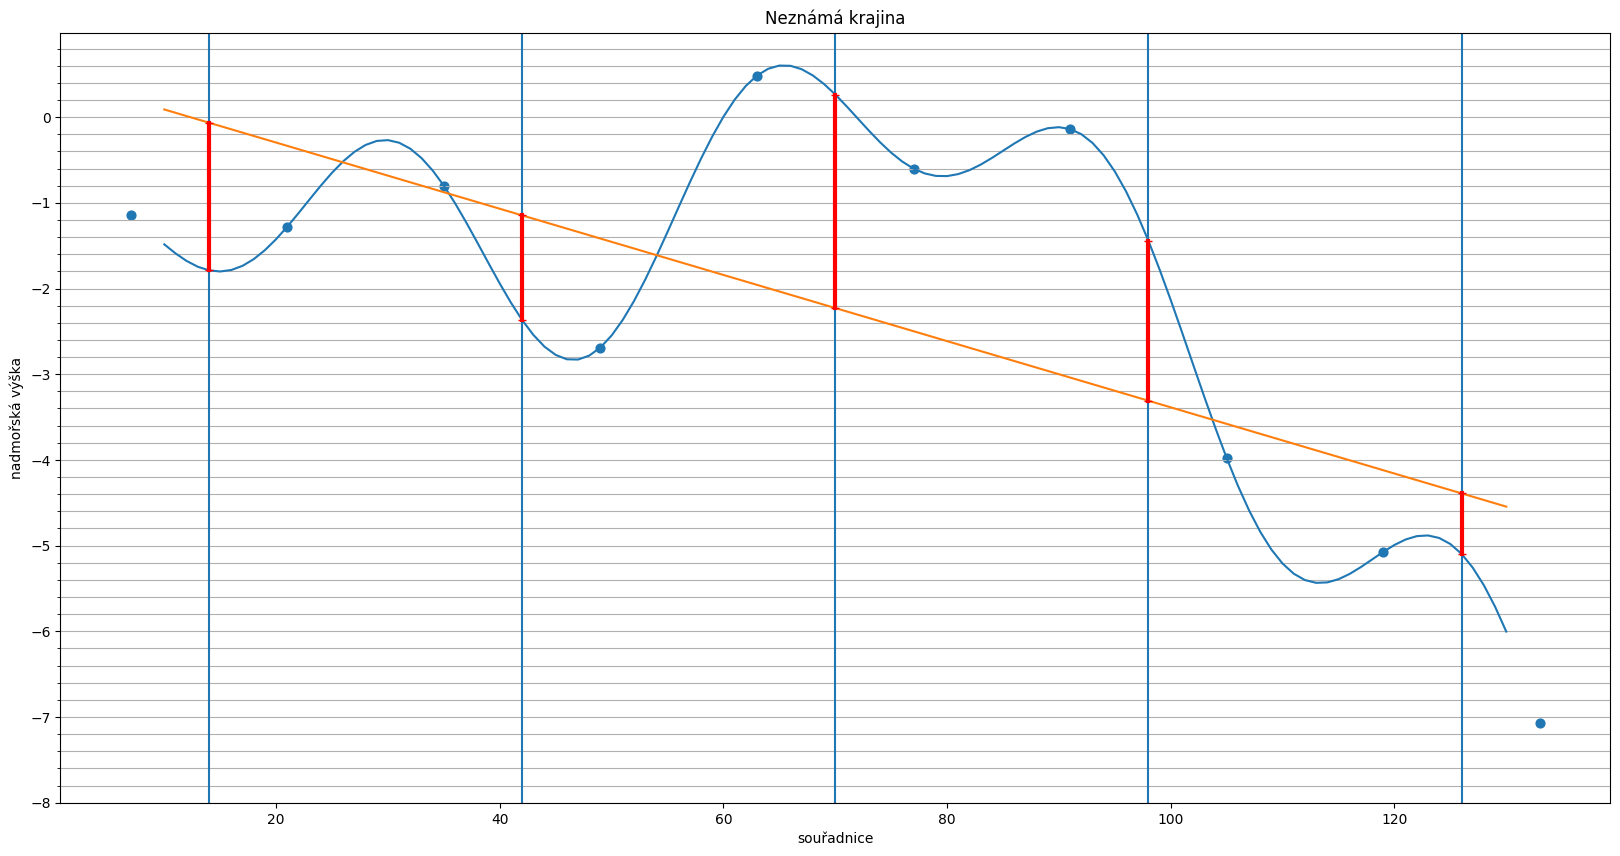

In [24]:
i = 1
df_krajina[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_krajina, CernaKrabicka)
zobraz_vysledek(df_krajina, f"predikce_krabickou_{i}");

### Úkol 3:

Ohodnoť kvalitu odhadu černé krabičky pomocí metriky, kterou jsi navrhla v úkolu 2. Je tvůj odhad lepší? 
(stačí nám zavolat funkci `moje_metrika` na příslušné sloupečky dataframu)

In [25]:
# řešení úkolu 3 
print("Moje hodnocení: ", moje_metrika(df_krajina["y_test"], df_krajina[f"predikce_krabickou_{i}"]))

Moje hodnocení:  14.648724094946882


# Další černé krabičky

Zkusme ještě další krabičky. Prohlédni si pozorně obrázky. Zamysli se, zda hodnocení pomocí tvé metriky odpovídá visuálnímu dojmu.

Správně bylo -1.8, předpovězeno -1.1. Absolutní chyba je +0.6.
Správně bylo -2.4, předpovězeno -1.9. Absolutní chyba je +0.5.
Správně bylo +0.3, předpovězeno +0.1. Absolutní chyba je -0.2.
Správně bylo -1.4, předpovězeno -1.3. Absolutní chyba je +0.2.
Správně bylo -5.1, předpovězeno -5.3. Absolutní chyba je -0.2.
Moje hodnocení:  0.7726993214095905


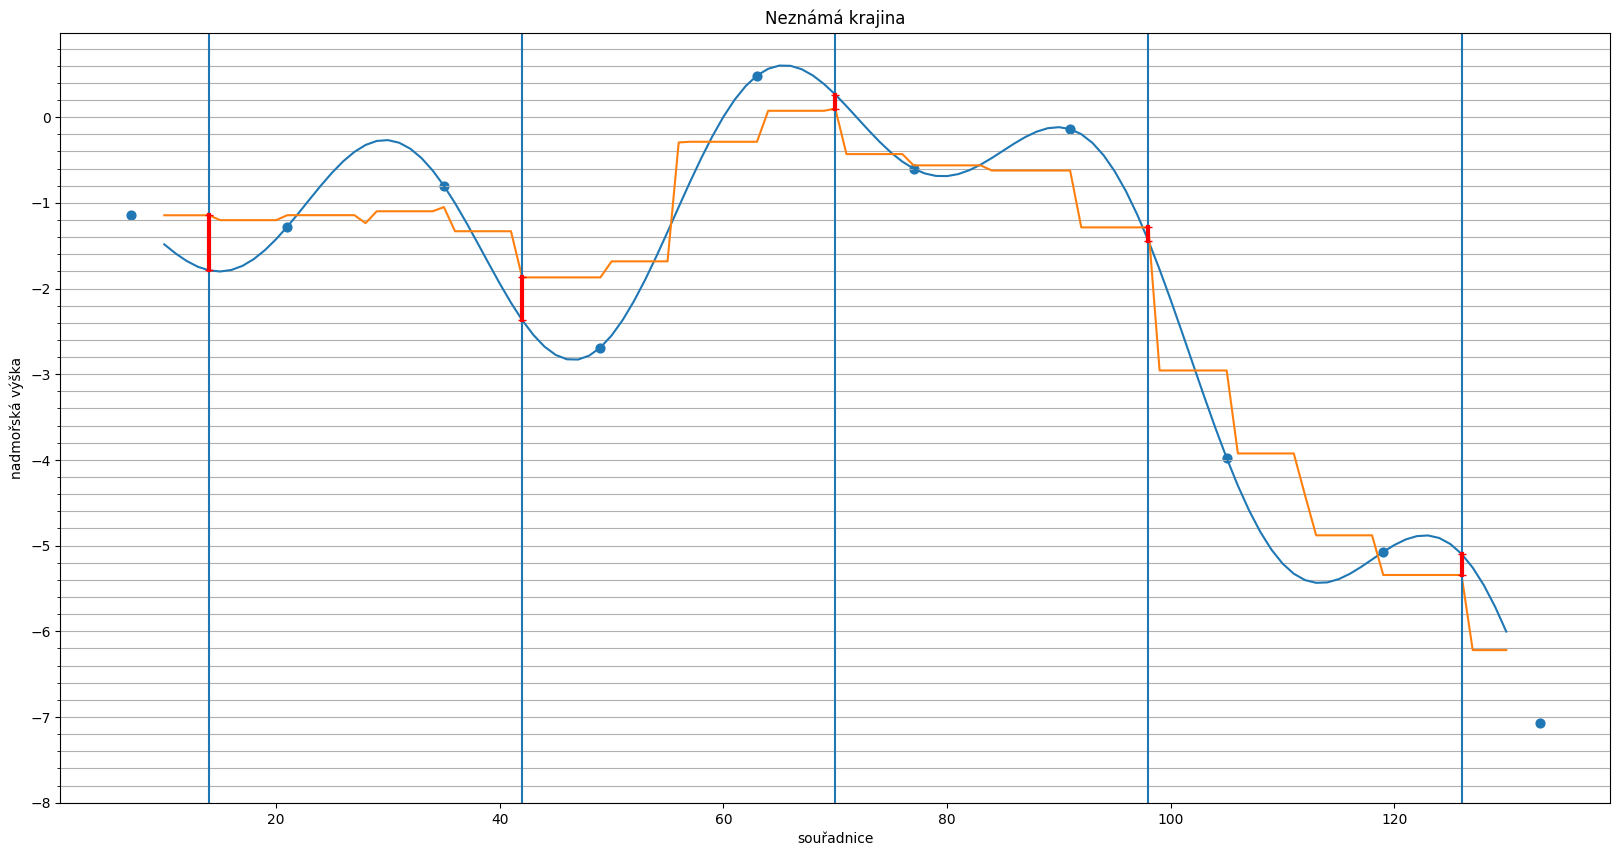

In [26]:
from sklearn.ensemble import RandomForestRegressor as CernaKrabicka

i = 2
df_krajina[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_krajina, CernaKrabicka)
zobraz_vysledek(df_krajina, f"predikce_krabickou_{i}");
print("Moje hodnocení: ", moje_metrika(df_krajina["y_test"], df_krajina[f"predikce_krabickou_{i}"]))

Správně bylo -1.8, předpovězeno -1.2. Absolutní chyba je +0.6.
Správně bylo -2.4, předpovězeno -0.9. Absolutní chyba je +1.5.
Správně bylo +0.3, předpovězeno -0.5. Absolutní chyba je -0.8.
Správně bylo -1.4, předpovězeno -2.2. Absolutní chyba je -0.7.
Správně bylo -5.1, předpovězeno -3.9. Absolutní chyba je +1.2.
Moje hodnocení:  5.179485610026742


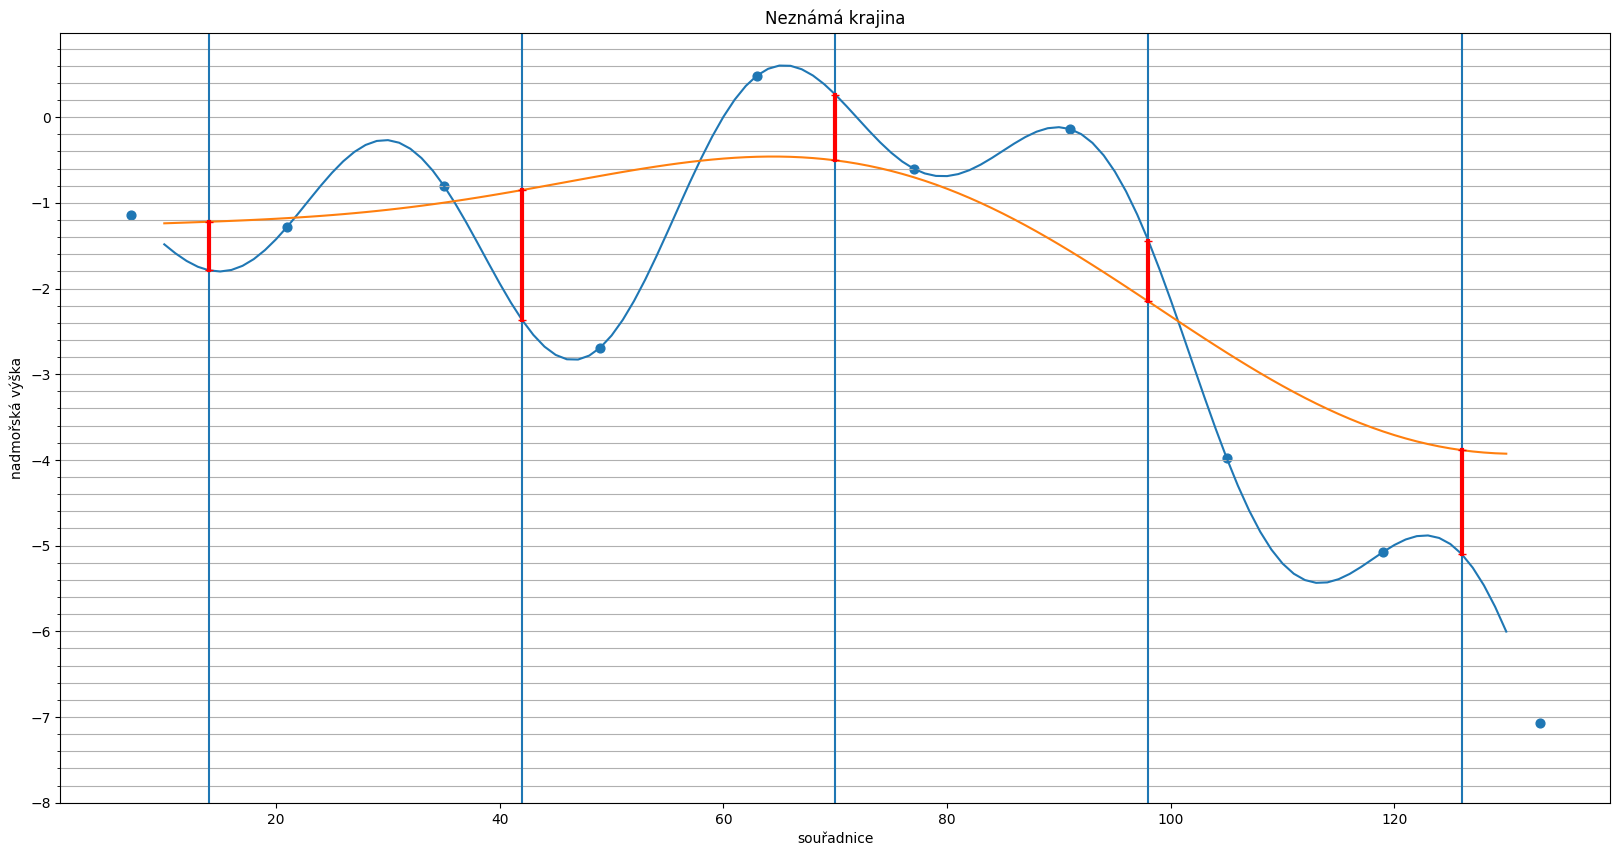

In [27]:
from sklearn.svm import SVR as CernaKrabicka

i=3
df_krajina[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_krajina, CernaKrabicka)

zobraz_vysledek(df_krajina, f"predikce_krabickou_{i}");
print("Moje hodnocení: ", moje_metrika(df_krajina["y_test"], df_krajina[f"predikce_krabickou_{i}"]))

Správně bylo -1.8, předpovězeno -1.8. Absolutní chyba je -0.1.
Správně bylo -2.4, předpovězeno -1.8. Absolutní chyba je +0.6.
Správně bylo +0.3, předpovězeno -0.4. Absolutní chyba je -0.7.
Správně bylo -1.4, předpovězeno -2.1. Absolutní chyba je -0.6.
Správně bylo -5.1, předpovězeno -5.4. Absolutní chyba je -0.3.
Moje hodnocení:  1.20167038320601


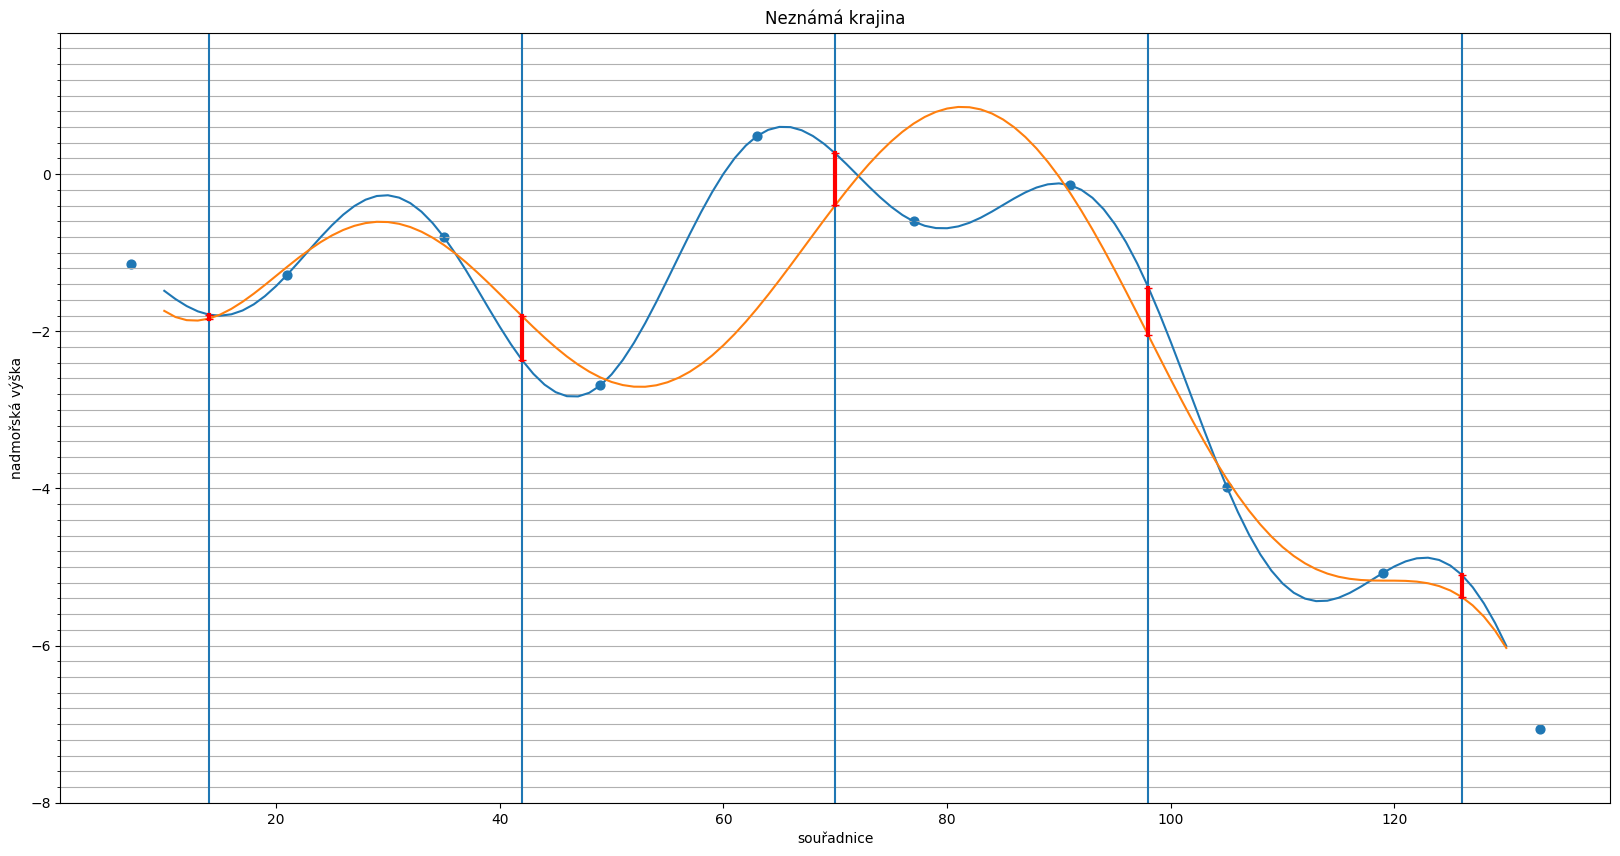

In [28]:
from sklearn.svm import SVR as CernaKrabicka

i=4
df_krajina[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_krajina, CernaKrabicka, C=10000)
zobraz_vysledek(df_krajina, f"predikce_krabickou_{i}");
print("Moje hodnocení: ", moje_metrika(df_krajina["y_test"], df_krajina[f"predikce_krabickou_{i}"]))

Správně bylo -1.8, předpovězeno -2.1. Absolutní chyba je -0.3.
Správně bylo -2.4, předpovězeno -2.2. Absolutní chyba je +0.2.
Správně bylo +0.3, předpovězeno -1.9. Absolutní chyba je -2.2.
Správně bylo -1.4, předpovězeno -2.2. Absolutní chyba je -0.8.
Správně bylo -5.1, předpovězeno -2.9. Absolutní chyba je +2.2.
Moje hodnocení:  10.443174306382092


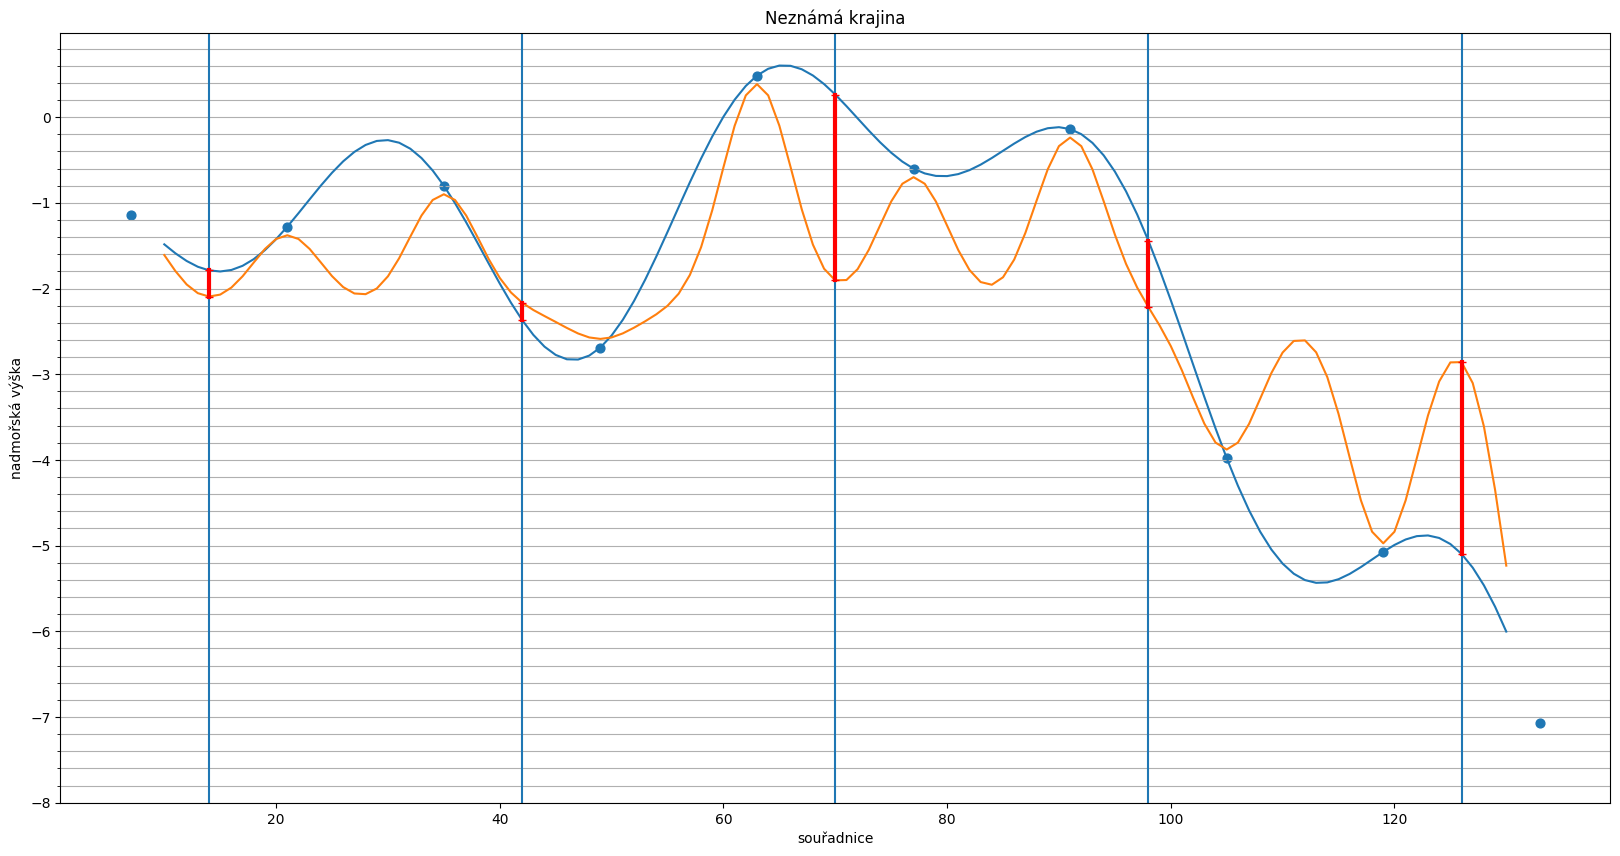

In [29]:
from sklearn.svm import SVR as CernaKrabicka

i = 5
df_krajina[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_krajina, CernaKrabicka, gamma=1000, C=10)
zobraz_vysledek(df_krajina, f"predikce_krabickou_{i}");
print("Moje hodnocení: ", moje_metrika(df_krajina["y_test"], df_krajina[f"predikce_krabickou_{i}"]))

Poslední příklad ilustruje užitečnost **testovací množiny**.

## Úkol 4:

 - Který z modelů krajiny se ti nejvíce líbí? 
 - Jaké jsou asi výhody a nevýhody jednotlivých modelů?
 - Všimni si posledního obrázku. Jak ohodnotí tvá metrika výsledek, použiješ-li hodnoty v bodech trénovací množiny? Jak dopadne na testovací množině?

Situaci, kdy model dává správnou odezvu pro data z **trénovací množiny**, ale špatně odhaduje vzory, které během učení nebyly k dispozici, říkáme **přeučení** (**overfitting**). Podobně jako když se student naučí vzorové odpovědi zpaměti, ale nepochopí zákonitosti (neumí **generalizovat**). 
Opačná situace se označuje jako **underfitting**, což je např. použití přímky (lineární regrese) k modelování zvlněné krajiny (nelineární funkce). 

![overfit_underfit_example](static/overfit.png)

## Hyper-parametry 

U příkladů výše jsme funkci `vyhodnot krabicku` předávali data a krabičku (model). Několikrát jsme si ale trochu pomohli a předali jsme tiše ještě nějaké další parametry.  Krabička totiž často umožňuje uživateli, aby si ji nakonfiguroval. V terminologii krabiček si můžeme představit, že krabička má na sobě různé páčky, kterými se dá seřídit. Těmito páčkami se nastavují tzv. **hyper-parametry** modelu. Všechny modely, které najdeš v knihovně Scikit-learn, mají nějaké defaultní nastavení a půjdou použít i bez toho, aby ses nastavením těchto **hyper-parametrů** zabývala.  
V případě, že model nedává uspokojivý výsledek, můžeš zkusit tyto parametry upravit, např. vyzkoušet několik různých nastavení a porovnat hodnotu metriky na testovací množině.  
K problému hledání vhodných **hyper-parametrů** se vrátíme na začátku příští hodiny. 

